Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import re

The PanCancer model metrics pulbished by Chang et al., 2024 for the following dataset: 1. chowell_train, chowell_test, msk1

In [2]:
LLR6 = {
    'chowell_tran': {
        'auc': [0.7441, 0.7441 - 1.96 * (0.008886 / (10000 ** 0.5)), 0.7441 + 1.96 * (0.008886 / (10000 ** 0.5))],
        'prauc': [0.5501, 0.0159, 0.4868, 0.6210],
        'accuracy': [0.6928, 0.0088, 0.6563, 0.7263],
        'f1': 0.5495,
        'mcc': 0.4812,
        'BA': 0.6407,
        'performance': 0.6283,
    },
    'chowell_test': {
        'auc': [0.7155, 0.7155 - 1.96 * (0.035784 / (10000 ** 0.5)), 0.7155 + 1.96 * (0.035784 / (10000 ** 0.5))],
        'prauc': [0.5302, 0.0599, 0.2869, 0.7404],
        'accuracy': [0.6803, 0.0305, 0.5648, 0.7927],
        'f1': 0.5289,
        'mcc': 0.4652,
        'BA': 0.6176,
        'performance': 0.6072,
    },
    'msk1': {
        'auc': [0.70, 0.65, 0.75]
    },
}

Functions to perform the posprocessing (model evaluation):

In [3]:
def extract_auc_value(script_tags):
    for script in script_tags:
        if script.string and 'AUC =' in script.string:
            match = re.search(r'AUC\s*=\s*(\d+\.\d+)', script.string)
            if match:
                return float(match.group(1))
    return None


def compare_metric(value, std, ci_lower=None, ci_upper=None, metric_name=""):
    if value > std:
        comparison = "higher"
    elif value < std:
        comparison = "lower"
    else:
        comparison = "equal"

    print(f"The extracted {metric_name} value {value:.4f} is {comparison} than the standard {metric_name} value {std:.4f}.")

    # Only check the confidence interval if both ci_lower and ci_upper are provided
    if ci_lower is not None and ci_upper is not None:
        if ci_lower <= value <= ci_upper:
            print(f"The extracted {metric_name} value {value:.4f} is within the confidence interval ({ci_lower}, {ci_upper}).")
        else:
            print(f"The extracted {metric_name} value {value:.4f} is outside the confidence interval ({ci_lower}, {ci_upper}).")

def AUCMetric(soup, dataset_name):
    auc_value = extract_auc_value(soup.find_all('script'))
    if auc_value is None:
        print("AUC value not found.")
        return

    try:
        auc_data = LLR6[dataset_name]['auc']
        compare_metric(auc_value, auc_data[0], auc_data[1], auc_data[2], "AUC")
    except KeyError:
        print(f"No AUC information available for {dataset_name}.")

def extract_metrics(script_content, dataset_name):
    pattern = r'"name":\s*"(Precision|Recall|F-score)",\s*"type":\s*"scatter",\s*"x":\s*\[[0-9, ]+\],\s*"y":\s*\[([0-9.]+),\s*([0-9.]+)\]'
    matches = re.findall(pattern, script_content)

    results = {name: (round(float(y1), 4), round(float(y2), 4)) for name, y1, y2 in matches}
    print("Extracted Values:", results)

    f_score = results.get('F-score', (None,))[0]
    f1_score = LLR6.get(dataset_name, {}).get('f1')
    if f_score is not None and f1_score is not None:
        compare_metric(f_score, f1_score, metric_name="F-score")

def OtherMetrics(soup, dataset_name):
    script = soup.find('script', string=re.compile('Plotly.newPlot'))
    if script and script.string:
        extract_metrics(script.string, dataset_name)
    else:
        print('Plotly.newPlot script not found.')

def GetHTML(url, plot_type, dataset_name):
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Failed to fetch content: {e}")
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    if plot_type == 'auc':
        AUCMetric(soup, dataset_name)
    elif plot_type == 'metrics':
        OtherMetrics(soup, dataset_name)
    else:
        print("Unknown plot type.")


**YOU NEED TO INFORM WHICH DATASET TO USE** The options are: chowell_test, chowell_train, msk1. Select based on the plots you want to compare.

In [4]:
dataset_name = 'chowell_test'

In Galaxy, go to the ROC and AUC plot you want to evaluate, then locate the Download button (disk icon). Right-click on it, select 'Copy Link Address,' and paste it here.

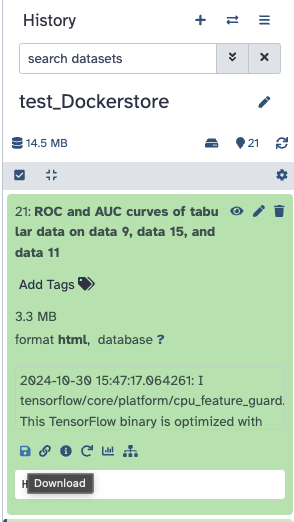

In [5]:
auc_plot_url = 'https://usegalaxy.org/api/datasets/f9cad7b01a472135fa4258a31fe1755d/display?to_ext=html'

Do the same procedure but for the Precision, Recall and f-score of tabular data plot.

In [6]:
metrics_url = 'https://usegalaxy.org/api/datasets/f9cad7b01a472135f5481594fb28c9e4/display?to_ext=html'

Start the evaluation

In [7]:
# Call functions to fetch HTML and extract metrics
GetHTML(auc_plot_url, 'auc', dataset_name)
GetHTML(metrics_url, 'metrics', dataset_name)

The extracted AUC value 0.7000 is lower than the standard AUC value 0.7155.
The extracted AUC value 0.7000 is outside the confidence interval (0.7147986336000001, 0.7162013664).
Extracted Values: {'Precision': (0.8622, 0.4091), 'Recall': (0.6518, 0.6983), 'F-score': (0.7424, 0.5159)}
The extracted F-score value 0.7424 is higher than the standard F-score value 0.5289.
